In [805]:
import numpy as np
import scipy as sp
from scipy.spatial import distance
class kEDMD:
    def __init__(self, X, Y, kernel="gaussian", **kwargs):
        """
        X: N_dim * M_data
        Y: N_dim * M_data
        """
        # For updating, this class needs to preserve previous data.
        self.X = X
        self.Y = Y
        self.kernel = kernel
        
        if self.kernel == "gaussian":
            assert "eps" in kwargs, "gaussian kernel needs eps param"
            self.eps = kwargs["eps"]
            self.f = self.gaussian
        elif self.kernel == "polynomial":
            assert ("p" in kwargs) and ("c" in kwargs), "polynomial kernel needs c and p param"
            self.p = kwargs["p"]
            self.c = kwargs["c"]
            if "gamma" in kwargs:
                self.gamma = kwargs["gamma"]
            else:
                self.gamma = 1.0
            self.f = self.polynomial
        
    def fit(self, truncation=1e-3):
        
        self.G = self.f(self.X, self.X)
        self.A = self.f(self.X, self.Y)
        
        # 低ランク近似
        self.U, self.s, self.V = sp.linalg.svd(self.G)
        mask = self.s > truncation
        self.s = self.s[mask]
        self.U = self.U[:, mask]
        self.V = self.V[mask, :]
        S_inv = np.diag(1/self.s)
        # カーネルクープマン行列を求める
        self.K = self.V.T @ S_inv @ self.U.T @ self.A
        self.calc_modes(truncation=truncation)
        return None
        
    def calc_modes(self, truncation=1e-3):
        # 固有値,固有ベクトルを求める
        self.eigenvalues, self.eigenvectors = sp.linalg.eig(self.K)

        # Kを求めるときに使った各データ点x1, x2, ..., xMを用いて，固有関数の値を求める
        # Gは対称行列なので下のコードのように転置を取らなくても良い
        # 低ランク近似（必要に応じて、必要なければtruncation=0にすれば良い）
        self.modes = sp.linalg.pinv(self.G.T @ self.eigenvectors, rtol=truncation) @ self.X.T
        return None

    def calc_eigenfunction(self, x):
        """
        x: N_dim * 1
        """
        M = self.X.shape[1] # num_data
        self.eigenfuncion = np.zeros([M])
        
        #次の座標を予測したいデータ点を入力とする固有関数の値を求める
        if self.kernel == "gaussian":
            phi_Xx = np.exp(-np.linalg.norm(self.X - x.reshape(-1,1), axis=0)**2/(2*(self.eps**2))) @ self.eigenvectors
        elif self.kernel == "polynomial":
            phi_Xx = (self.c + x.T @ self.X)**self.p @ self.eigenvectors
        return phi_Xx
        
    def predict(self, x):
        """
        x: N_dim * 1
        return: N_dim * 1
        """
        phi_Xx = self.calc_eigenfunction(x)
        return np.real((self.eigenvalues * phi_Xx.flatten()) @ self.modes)

    def gaussian(self, X, Y):
        """
        X: N_dim * M_data
        Y: N_dim * M_data
        return Gram matrix, ij element = k(x_j, y_i)
        """
        M = X.shape[1]
        G = np.zeros([M, M])
        for i in range(M):
            for j in range(M):
                G[i, j] += np.exp(-np.linalg.norm(Y[:, i] - X[:, j])**2/(2*(np.sqrt(2)**2)))
        return G
    def polynomial(self, X, Y):
        """
        c: param
        d: order
        X: N_dim * M_data
        Y: N_dim * M_data
        return Gram matrix, each element = k(x_i, y_i)
        """
        M = X.shape[1]
        G = np.zeros([M, M])
        for i in range(M):
            for j in range(M):
                G[i, j] += (self.gamma*(Y[:, i].T @X[:, j]) + self.c)**self.p
        return G
    @classmethod
    def svd_update(self, U, s, V, a, b, w=1):
        """
        a: col vector
        b: col vector
        """
        m = U.T @ a
        n = V @ b
        p = a - U @ m
        q = b - V.T @ n
        Ra = np.linalg.norm(p)
        Rb = np.linalg.norm(q)
        
        P = p/Ra
        Q = q/Rb
        
        K = np.append(m, Ra*w).reshape(-1,1) @ np.append(n, Rb*w).reshape(-1,1).T
        K[:-1, :-1] += np.diag(s)
        U_prime, s_prime, V_prime = np.linalg.svd(K)
        UpdatedU = np.hstack([U, P]) @ U_prime
        UpdatedV = np.hstack([V.T, Q]) @ V_prime.T
        
        return UpdatedU, s_prime, UpdatedV.T, U, P, U_prime

    def update(self, new_x, new_y, swap_index=0, truncation=1e-3, w=1, greedy=False):
        """
        Description:
            swap old data and new data from gramian G and covariance matrix A
            If swap_index = 0, swap oldest data. In other words, swap_index=0 means Sliding Window Update.
        Args:
            new_x, new_y: column vector(N_dim * 1)
        Return:
            Kernel Koopman Matrix
        """
        # swap old data and new data from Data matrix
        self.X = np.delete(self.X, swap_index, 1)
        self.X = np.insert(self.X, swap_index, new_x, 1)
        self.Y = np.delete(self.Y, swap_index, 1)
        self.Y = np.insert(self.Y, swap_index, new_y, 1)
        # calc kernel vector, k_ij = k(x_i, x_new)
        if self.kernel == "gaussian":
            d = np.exp(-np.linalg.norm(self.X- new_x.reshape(-1,1), axis=0)**2/(2*(self.eps**2)))
            self.A[:, swap_index] = np.exp(-np.linalg.norm(self.Y - new_x.reshape(-1,1), axis=0)**2/(2*(self.eps**2)))
            self.A[swap_index, :] = np.exp(-np.linalg.norm(self.X - new_y.reshape(-1,1), axis=0)**2/(2*(self.eps**2)))
            
        elif self.kernel == "polynomial":
            d = (self.c + new_x.reshape(1, -1) @ self.X)**self.p # x_2 ~ x_M+1
            self.A[:, swap_index] = (self.c + new_x.reshape(1, -1) @ self.Y)**self.p
            self.A[swap_index, :] = (self.c + new_y.reshape(1, -1) @ self.X)**self.p
            
        # Gの任意のデータを新しいデータにlow rank based updateする
        c = self.G[:, swap_index].reshape(-1,1)
        d = d.reshape(-1,1)
        b = np.zeros(self.V.shape[1]).reshape(-1,1)
        b[swap_index] += 1
        _U, _s, _V , U1,P1,U_prime1= self.svd_update(self.U, self.s, self.V, d-c, b, w)
        if greedy == True:
            _s = _s[:-1]
            _U = _U[:, :-1]
            _V = _V[:-1, :]
        else:
            mask = _s > truncation
            _s = _s[mask]
            _U = _U[:,mask]
            _V = _V[mask,:]
        
        # swap後の行列を転置して，再度更新
        c[swap_index] = d[swap_index]
        self.U, self.s, self.V, U2,P2,U_prime2 = self.svd_update(_V.T, _s, _U.T, d-c, b, w)

        # 求めたsを低ランク近似
        if greedy == True:
            self.s = self.s[:-1]
            self.U = self.U[:, :-1]
            self.V = self.V[:-1, :]
        else:
            mask = self.s > truncation
            self.s = self.s[mask]
            self.U = self.U[:, mask]
            self.V = self.V[mask, :]
        
        # 低ランク近似したものをGとする
        # self.s *= 0.95
        self.G = self.U @ np.diag(self.s) @ self.V
        
        # Gの逆行列を計算して新しいカーネルKoopman行列を求める
        S_inv = np.diag(1/self.s)
        G_inv = self.V.T @ S_inv @ self.U.T
        self.K = G_inv @ self.A
        return self.K, U1, P1, U_prime1, U2, P2, U_prime2
        

def polynomial_kernel(X, Y, gamma=1, d=5, c=1):
    """
    X: D * M次元
    Y: D * M次元
    return Gram matrix, each element = k(x_i, y_i)
    """
    M = X.shape[1]
    G = np.zeros([M, M])
    for i in range(M):
        for j in range(M):
            G[i, j] += (gamma*(Y[:, i].T @X[:, j]) + c)**d
    return G

In [719]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def lorentz(t, x, sigma, rho, beta):
    dx0dt = sigma * (x[1] - x[0])
    dx1dt = rho * x[0] - x[1] - x[0]*x[2]
    dx2dt = x[0] * x[1] - beta * x[2]
    return [dx0dt, dx1dt, dx2dt]

time_step = [0, 1]
sigma = 10
rho = 28
beta = 8
np.random.seed(100)
initial_value = np.random.uniform(low=-15, high=15, size=3)
sol_lorentz = solve_ivp(lorentz, t_span=time_step, y0=initial_value, args=[sigma, rho, beta], rtol=1e-8, t_eval=np.arange(0, 1, 0.01))
solution_lorentz = (sol_lorentz.y - np.min(sol_lorentz.y, axis=1).reshape(-1, 1)) / (np.max(sol_lorentz.y, axis=1) - np.min(sol_lorentz.y, axis=1)).reshape(-1,1)
initial_value = (initial_value.reshape(-1,1) - np.min(sol_lorentz.y, axis=1).reshape(-1, 1)) / (np.max(sol_lorentz.y, axis=1) - np.min(sol_lorentz.y, axis=1)).reshape(-1,1)

x = solution_lorentz[0]
y = solution_lorentz[1]
z = solution_lorentz[2]
X_lorentz_old = solution_lorentz[:, :-2]
Y_lorentz_old = solution_lorentz[:, 1:-1]
X_lorentz_new = solution_lorentz[:, 1:-1]
Y_lorentz_new = solution_lorentz[:, 2:]
print("done")

done


In [823]:
from onlineSVD import svd_update
# kernel EDMD
# 閾値
# カーネルKoopman行列を求める
new_x = solution_lorentz[:, -2]
new_y = solution_lorentz[:, -1]
new_x = solution_lorentz[:, 0]
new_y = solution_lorentz[:, 1]
swap_index = 1
X_lorentz_new = np.delete(X_lorentz_old, swap_index, 1)
X_lorentz_new = np.insert(X_lorentz_new, swap_index, new_x, 1)
Y_lorentz_new = np.delete(Y_lorentz_old, swap_index, 1)
Y_lorentz_new = np.insert(Y_lorentz_new, swap_index, new_y, 1)
kedmd_old = kEDMD(X_lorentz_old, Y_lorentz_old, kernel="polynomial", p=3, c=1)
kedmd_new = kEDMD(X_lorentz_new, Y_lorentz_new, kernel="polynomial", p=3, c=1)
#kedmd = kEDMD(X_lorentz[:, :-1], Y_lorentz[:, :-1], kernel="gaussian", eps=np.sqrt(2))

# truncation=1e-2以下の特異値を削りつつ，低ランク近似
kedmd_old.fit(truncation=1e-2)
kedmd_new.fit(truncation=1e-2)
print("fit done")

# 更新前の特異値
print("更新前の特異値: ", kedmd_old.s[kedmd_old.s>1e-2])

# 更新後の特異値をアルゴリズムによって求める
_, U1, P1, U_prime1, U2, P2, U_Prime2 = kedmd_old.update(new_x=new_x, new_y=new_y, swap_index=swap_index, truncation=1e-2, w=1, greedy=False)

print("更新後の特異値: ",kedmd_old.s)

# swap_index番目のデータと新しいデータをスワップしたデータの特異値を直接求める
print("真の特異値: ", kedmd_new.s[kedmd_new.s>1e-2])
print("====")
print((np.hstack([U1, P1]) @ U_prime1).T @ (np.hstack([U1, P1]) @ U_prime1))
# 予測値を求める
# pred = []
# print(X_lorentz.shape)
# for x in X_lorentz.T:
#     pred.append(kedmd.predict(x))
# print("done")

fit done
更新前の特異値:  [6.91394775e+02 1.36762455e+02 3.73690056e+01 1.19785257e+01
 3.25349490e+00 1.17859177e+00 3.72318433e-01 1.68298697e-01
 6.23826518e-02 3.37790588e-02 1.45988885e-02]
更新後の特異値:  [6.91607280e+02 1.37255172e+02 3.74220770e+01 1.20616646e+01
 3.25139792e+00 1.17836440e+00 4.09332033e-01 1.75033727e-01
 6.68502137e-02 3.52433462e-02 1.46771915e-02]
真の特異値:  [6.91607280e+02 1.37255172e+02 3.74220770e+01 1.20616646e+01
 3.25139792e+00 1.17836440e+00 4.09332078e-01 1.75033764e-01
 6.68502864e-02 3.52433683e-02 1.46771956e-02]
====
[[ 1.00000000e+00 -2.62688279e-16  1.67888265e-16 -3.48123189e-17
   2.73237198e-17 -4.55609593e-17  4.97632038e-16  6.21111271e-16
  -3.70867648e-16  2.46119596e-16 -2.66955680e-16 -8.43021307e-18]
 [-2.62688279e-16  1.00000000e+00 -1.71451237e-17  1.24806084e-16
   7.76178074e-17  5.49501341e-18  5.98203140e-16  6.77815906e-16
  -5.15256488e-16  3.23924884e-16 -3.07616441e-16  2.78309258e-17]
 [ 1.67888265e-16 -1.71451237e-17  1.00000000e+00 -2.

In [756]:
insert_idx = -1
_rng = np.random.default_rng(10)
A = _rng.integers(0, 100,(5,2))
print(A.shape)
A = A @ A.T
for i in range(3):
    rng = np.random.default_rng(i)
    new_d = rng.random((5))*100
    rem_c = A[:, -1]
    new_a = (new_d-rem_c).reshape(-1,1)
    U, s_0, V = np.linalg.svd(A)
    updated_A = A[:, :-1]
    updated_A = np.hstack((updated_A, new_d.reshape(-1,1)))
    b = np.zeros(V.shape[1]).reshape(-1, 1)
    b[insert_idx] += 1
    U, s, V = svd_update(U, s_0, V, new_a, b)
    _U, _s, _V = np.linalg.svd(updated_A)
    print("swap1")
    print("from alg")
    print(s[s>1e-5])
    print("from svd of updated matrix")
    print(_s[_s>1e-5])
    updated_B = updated_A.T[:, :-1]
    updated_B = np.hstack((updated_B, new_d.reshape(-1,1)))
    mask = s > 1e-5
    s = s[mask]
    U = U[:, mask]
    V = V[mask, :]
    rem_c[-1] = new_d[-1]
    new_a = (new_d - rem_c).reshape(-1,1)
    U,s,V = svd_update(V.T, s, U.T, new_a, b)
    _U,_s,_V = np.linalg.svd(updated_B)
    print("swap2")
    print(s[s > 1e-5])
    #print(s)
    print(_s[_s > 1e-5])

(5, 2)
swap1
from alg
[35105.74621754  1063.2417141     64.18895691]
from svd of updated matrix
[35105.74621754  1063.2417141     64.18895691]
swap2
[3.09297947e+04 8.62703390e+02 9.89637387e+01 1.78077852e+01]
[3.09297947e+04 8.62703218e+02 9.86868542e+01 1.78577519e+01]
swap1
from alg
[35105.76348118  1064.8218751     99.7986479 ]
from svd of updated matrix
[35105.76348118  1064.8218751     99.7986479 ]
swap2
[30929.95087321   870.53556538    92.19299992    69.31314811]
[30929.95087177   870.53376945    92.08961217    69.39110819]
swap1
from alg
[35105.78075728  1063.21942383    47.05937473]
from svd of updated matrix
[35105.78075728  1063.21942383    47.05937473]
swap2
[3.09299072e+04 8.62300279e+02 8.45039826e+01 2.46913834e+01]
[3.09299072e+04 8.62300279e+02 8.44962034e+01 2.46936566e+01]


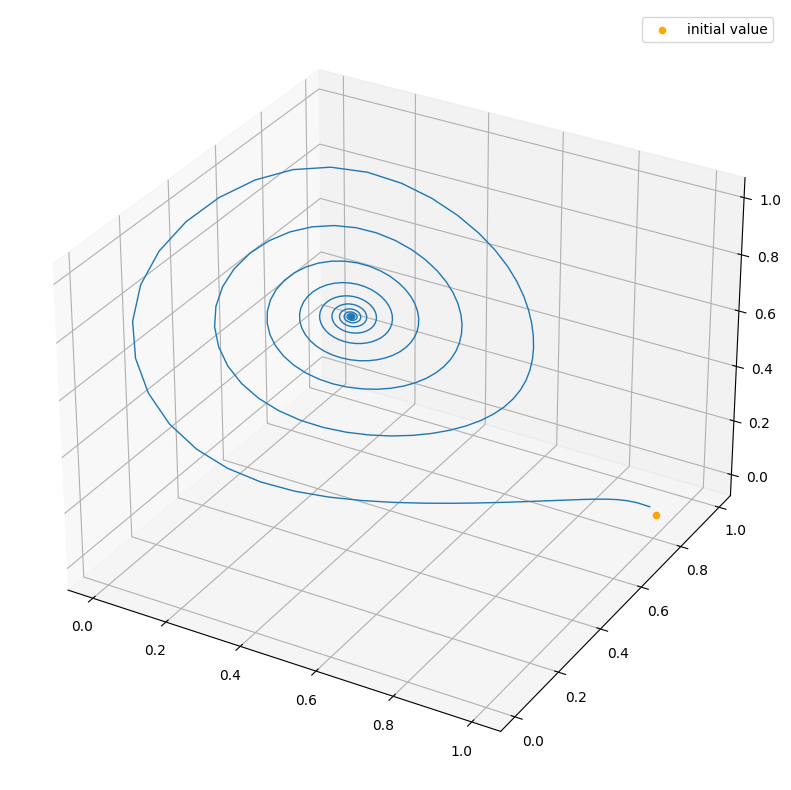

In [624]:
#y_kedmd = np.real((kedmd.eigenvalues * kedmd.eigenfunction) @ kedmd.modes).T
y_kedmd = np.array(pred).T
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(initial_value[0], initial_value[1], initial_value[2], color="orange", label="initial value")
ax.plot(y_kedmd[0], y_kedmd[1], y_kedmd[2], linewidth=1)
plt.legend(loc="upper right", fontsize=10)
plt.show()

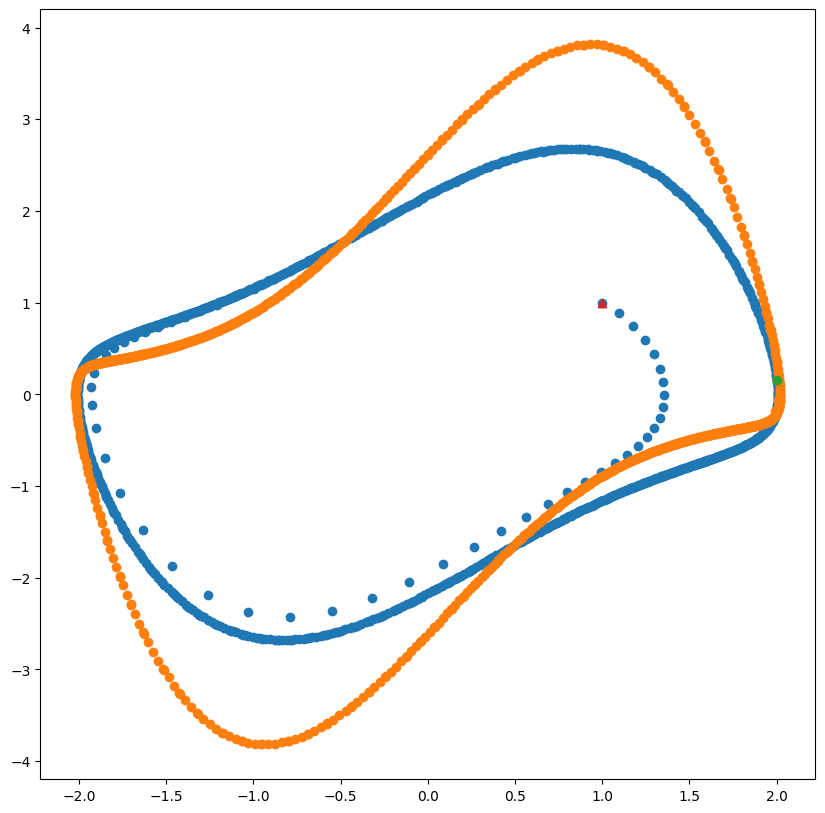

In [5]:
def van_der_pol(t, x, mu):
    dx0dt = x[1]
    dx1dt = mu*(1 - x[0]**2)*x[1] - x[0]
    return [dx0dt, dx1dt]
initial_value = [1., 1.]
time_step1 = (0, 100)
time_step2 = (100, 200)
mu_0 = 1
mu_1 = 2
T = 100
X_t = []
Y_t = []
solution1 = solve_ivp(van_der_pol, t_span=time_step1, y0=initial_value, args=[mu_0],rtol=1e-8, t_eval=np.arange(0,100,0.1))
medium_value = solution1.y[:, -1]

solution2 = solve_ivp(van_der_pol, t_span=time_step2, y0=medium_value, args=[mu_1],rtol=1e-8, t_eval=np.arange(100,200,0.1))
plt.figure(figsize=(10, 10))
plt.scatter(solution1.y[0], solution1.y[1])
plt.scatter(solution2.y[0], solution2.y[1])
plt.scatter(medium_value[0], medium_value[1])
plt.scatter(initial_value[0], initial_value[1], marker="^")
plt.show()

In [839]:
# generate mesh VdP data
def van_der_pol(t, x, mu):
    dx0dt = x[1]
    dx1dt = mu*(1 - x[0]**2)*x[1] - x[0]
    return [dx0dt, dx1dt]
mesh_num = 3
dt=0.01
step = 10
mu = 1
T = dt * (step+1)
time_step = (0, T)

# First Quadrant (1 ~ 2)
x1 = np.linspace(1, 2, mesh_num)
y1 = np.linspace(1, 2, mesh_num)
X1, Y1 = np.meshgrid(x1, y1)
InitDataPoint = np.c_[np.ravel(X1), np.ravel(Y1)]

# Third Quadrant (-2 ~ -1)
x2 = np.linspace(-2, -1, mesh_num)
y2 = np.linspace(-2, -1, mesh_num)
X2, Y2 = np.meshgrid(x2, y2)
InitNewDataPoint = np.c_[np.ravel(X2), np.ravel(Y2)]

rng = np.random.default_rng(seed=0)
InitTestDataPoint_1 = 1*rng.random((1,2))+1
sol_test = solve_ivp(van_der_pol, t_span=time_step, y0=InitTestDataPoint_1.flatten(), args=[mu], rtol=1e-8, t_eval=np.arange(0, T, dt))
TestDataPoint_1 = sol_test.y

rng = np.random.default_rng(seed=0)
InitTestDataPoint_3 = 1*rng.random((1,2))-2
sol_test = solve_ivp(van_der_pol, t_span=time_step, y0=InitTestDataPoint_3.flatten(), args=[mu], rtol=1e-8, t_eval=np.arange(0, T, dt))
TestDataPoint_3 = sol_test.y

TrainDataPoints = InitDataPoint[0].reshape(-1,1)
OnlineDataPoints = InitNewDataPoint[0].reshape(-1,1)
for x in InitDataPoint:
    sol_train = solve_ivp(van_der_pol, t_span=time_step, y0=x, args=[mu], rtol=1e-8, t_eval=np.arange(0, T, dt))
    TrainDataPoints = np.hstack([TrainDataPoints, sol_train.y])
    
for x in InitNewDataPoint:
    sol_online = solve_ivp(van_der_pol, t_span=time_step, y0=x, args=[mu], rtol=1e-8, t_eval=np.arange(0, T, dt))
    OnlineDataPoints = np.hstack([OnlineDataPoints, sol_online.y])
TrainDataPoints = TrainDataPoints[:, 1:]
OnlineDataPoints = OnlineDataPoints[:, 1:]

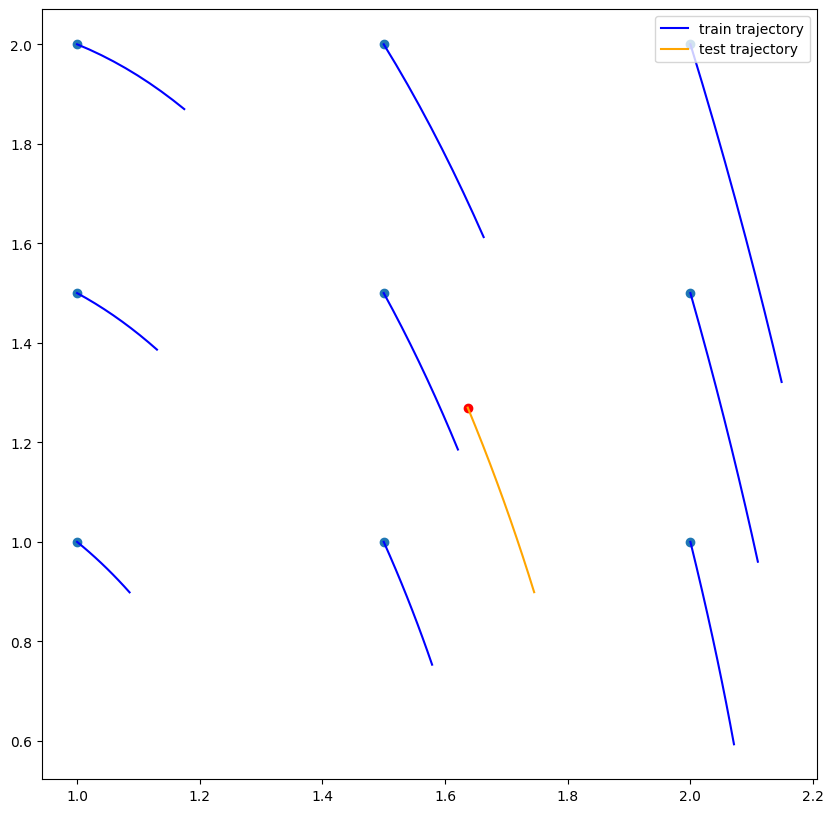

In [840]:
# メッシュをプロット
LABEL=True
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X1, Y1)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(TrainDataPoints[0, i*step+i:(i+1)*step+i], TrainDataPoints[1, i*step+i:(i+1)*step+i], color="blue", label="train trajectory")
        LABEL=False
    else:
        ax.plot(TrainDataPoints[0, i*step+i:(i+1)*step+i], TrainDataPoints[1, i*step+i:(i+1)*step+i], color="blue")
ax.scatter(InitTestDataPoint_1[:,0], InitTestDataPoint_1[:,1], color="red")
ax.plot(TestDataPoint_1[0, :], TestDataPoint_1[1,:], color="orange", label="test trajectory")
ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
plt.show()

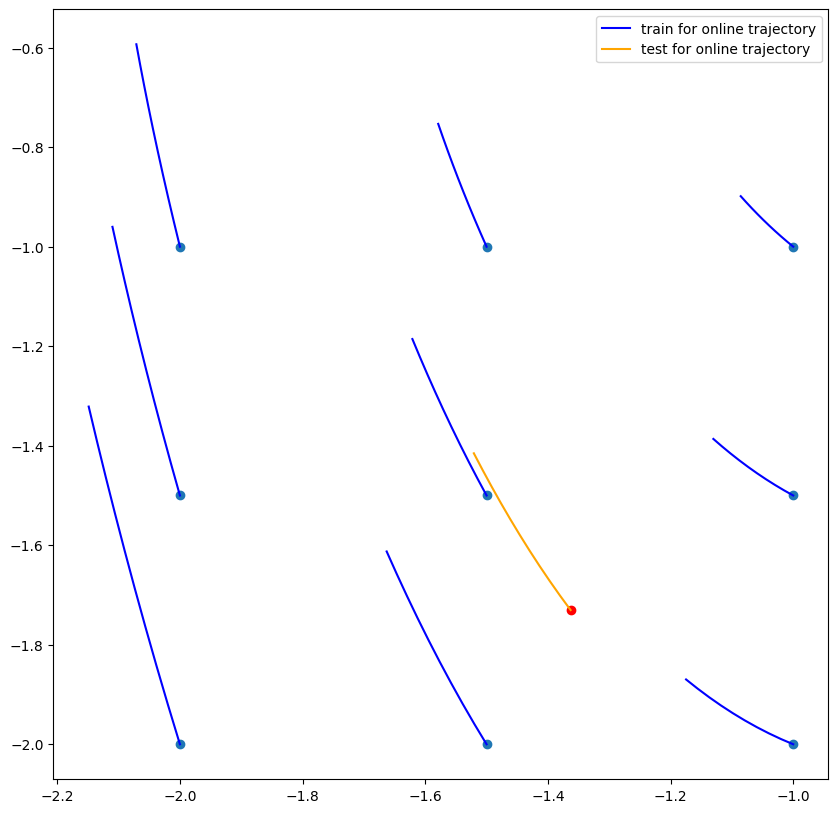

In [841]:
# 3象限のメッシュをプロット
LABEL=True
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X2, Y2)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(OnlineDataPoints[0, i*step+i:(i+1)*step+i], OnlineDataPoints[1, i*step+i:(i+1)*step+i], color="blue", label="train for online trajectory")
        LABEL=False
    else:
        ax.plot(OnlineDataPoints[0, i*step+i:(i+1)*step+i], OnlineDataPoints[1, i*step+i:(i+1)*step+i], color="blue")
ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
ax.scatter(InitTestDataPoint_3[:,0], InitTestDataPoint_3[:,1], color="red")
ax.plot(TestDataPoint_3[0, :], TestDataPoint_3[1,:], color="orange", label="test for online trajectory")
ax.legend()
plt.show()

fit done


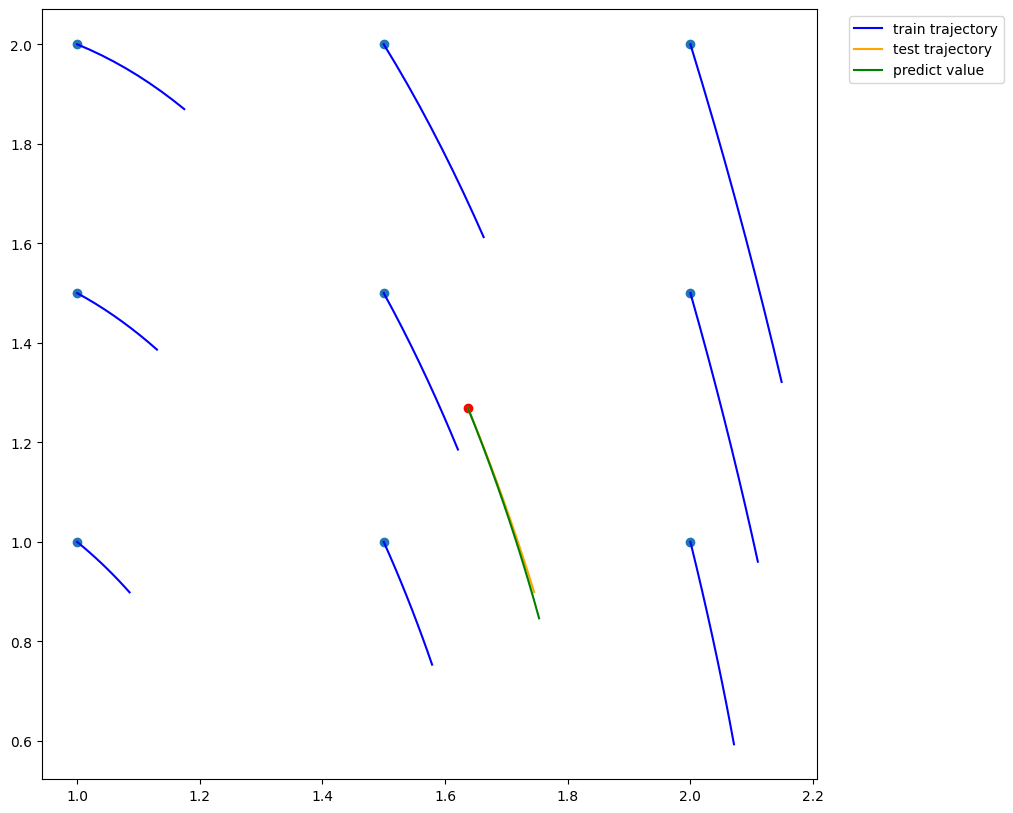

In [842]:
# kedmdにより学習
# スナップショットペアを作成
# first quadrant
mask_x = [True for _ in range(TrainDataPoints.shape[1])]
mask_y = [True for _ in range(TrainDataPoints.shape[1])]
mask_y[0] = False
for i in range(mesh_num**2):
    mask_x[(i+1) * step + i] = False
    if not (i+1) * step + i + 1 > len(mask_y)-1:
        mask_y[(i+1) * step + i + 1] = False
X_mesh = TrainDataPoints[:, mask_x]
Y_mesh = TrainDataPoints[:, mask_y]
kedmd_mesh = kEDMD(X=X_mesh, Y=Y_mesh, kernel="polynomial", p=1, c=1)
#kedmd_mesh = kEDMD(X=X_mesh, Y=Y_mesh, kernel="gaussian", eps=np.sqrt(2))
kedmd_mesh.fit()
print("fit done")
preds = [InitTestDataPoint_1.flatten()]
pred = kedmd_mesh.predict(InitTestDataPoint_1.reshape(-1, 1))
preds.append(pred)
for i in range(TestDataPoint_1.shape[1]-1):
    pred = kedmd_mesh.predict(pred)
    preds.append(pred)
preds = np.array(preds)

#################### 描画　######################
LABEL=True
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X1, Y1)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(TrainDataPoints[0, i*step+i:(i+1)*step+i], TrainDataPoints[1, i*step+i:(i+1)*step+i], color="blue", label="train trajectory")
        LABEL=False
    else:
        ax.plot(TrainDataPoints[0, i*step+i:(i+1)*step+i], TrainDataPoints[1, i*step+i:(i+1)*step+i], color="blue")
ax.scatter(InitTestDataPoint_1[:,0], InitTestDataPoint_1[:,1], color="red")
ax.plot(TestDataPoint_1[0, :], TestDataPoint_1[1,:], color="orange", label="test trajectory")
ax.plot(preds[:,0], preds[:,1], label="predict value", color="green")
ax.legend(bbox_to_anchor=(1.25, 1), loc="upper right")
plt.show()

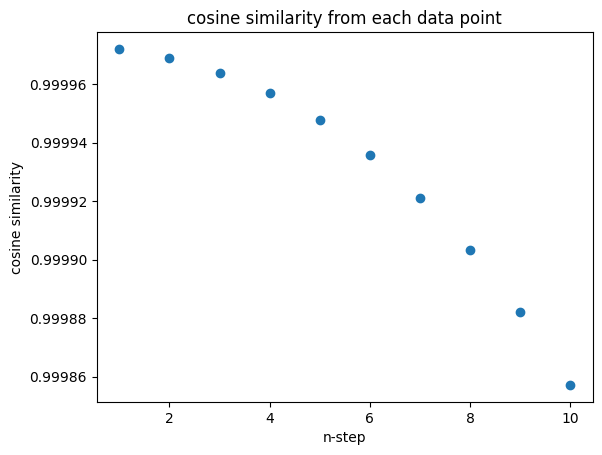

In [843]:
# ベクトル場の比較
vec_pred = preds[1:, :] - preds[:-1, :]
vec_test = (TestDataPoint_1[:, 1:] - TestDataPoint_1[:, :-1]).T
cossim = []
norms = []
for i in range(vec_pred.shape[0]-1):
    v_p = vec_pred[i, :]
    v_t = vec_test.T[:, i]
    cossim.append(np.dot(v_t, v_p) / ((np.linalg.norm(v_t) * np.linalg.norm(v_p))))
    norms.append(np.linalg.norm(v_p-v_t))
cossim = np.array(cossim)
#sim = (sim - sim.min()) / (sim.max() - sim.min())
plt.scatter(np.arange(1, vec_pred.shape[0]), cossim, label="cosine similarity")
#plt.ylim(sim.min()-0.001, sim.max()+0.0001)
plt.title("cosine similarity from each data point")
plt.ylabel("cosine similarity")
plt.xlabel("n-step")
plt.show()

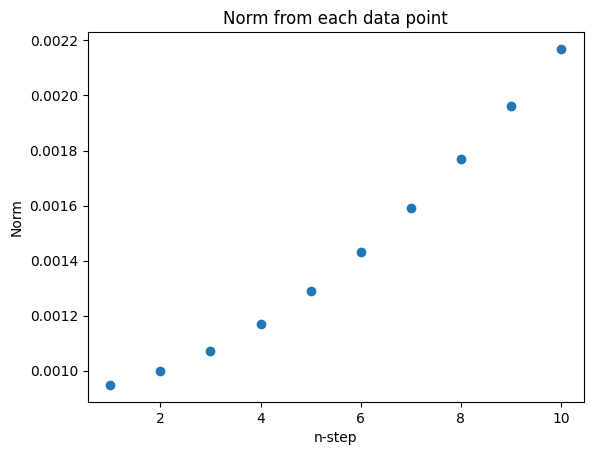

In [844]:
# normの比較
plt.scatter(np.arange(1, vec_pred.shape[0]), norms, label="RMSE")
plt.title("Norm from each data point")
plt.ylabel("Norm")
plt.xlabel("n-step")
plt.show()

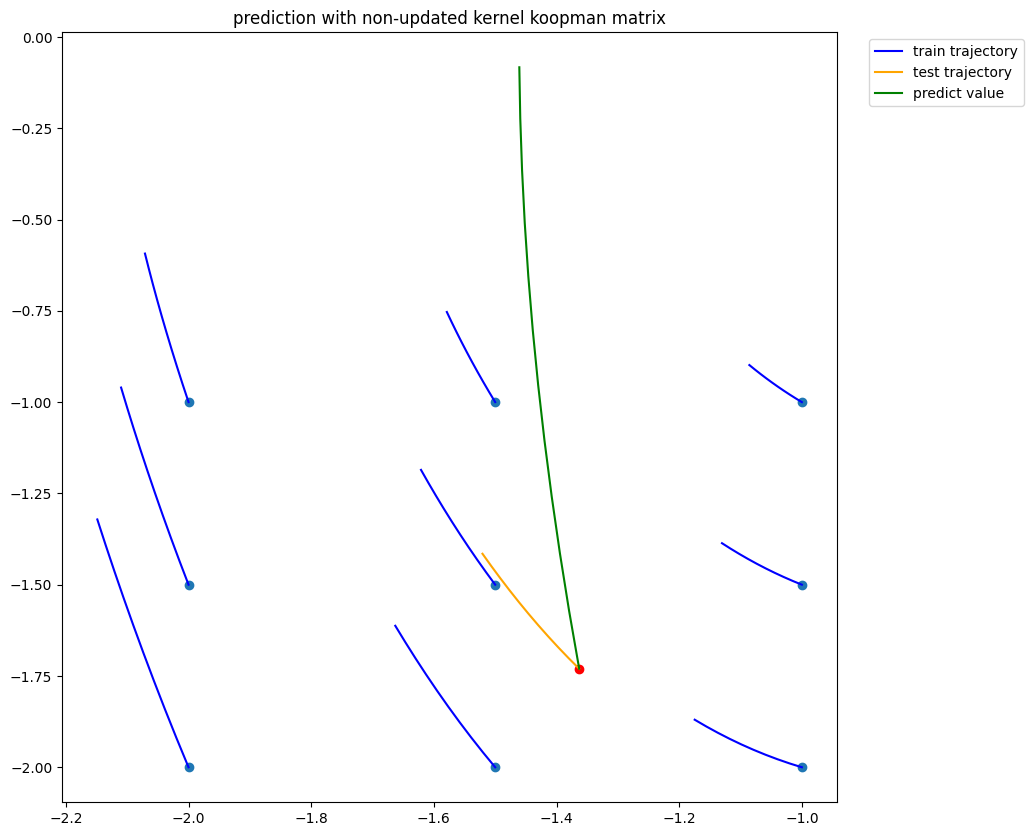

In [845]:
# third quadrant
preds_3rd = [InitTestDataPoint_3.flatten()]
pred = kedmd_mesh.predict(InitTestDataPoint_3.reshape(-1, 1))
preds_3rd.append(pred)
for i in range(TestDataPoint_3.shape[1]-1):
    pred = kedmd_mesh.predict(pred)
    preds_3rd.append(pred)
preds_3rd = np.array(preds_3rd)

#################### 描画　######################
LABEL=True
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X2, Y2)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(OnlineDataPoints[0, i*step+i:(i+1)*step+i], OnlineDataPoints[1, i*step+i:(i+1)*step+i], color="blue", label="train trajectory")
        LABEL=False
    else:
        ax.plot(OnlineDataPoints[0, i*step+i:(i+1)*step+i], OnlineDataPoints[1, i*step+i:(i+1)*step+i], color="blue")
ax.scatter(InitTestDataPoint_3[:,0], InitTestDataPoint_3[:,1], color="red")
ax.plot(TestDataPoint_3[0, :], TestDataPoint_3[1,:], color="orange", label="test trajectory")
ax.plot(preds_3rd[:,0], preds_3rd[:,1], label="predict value", color="green")
ax.set_title("prediction with non-updated kernel koopman matrix")
ax.legend(bbox_to_anchor=(1.25, 1), loc="upper right")
plt.show()

In [855]:
# online更新
mask_x = [True for _ in range(TrainDataPoints.shape[1])]
mask_y = [True for _ in range(TrainDataPoints.shape[1])]
mask_y[0] = False
for i in range(mesh_num**2):
    mask_x[(i+1) * step + i] = False
    if not (i+1) * step + i + 1 > len(mask_y)-1:
        mask_y[(i+1) * step + i + 1] = False
X_mesh = TrainDataPoints[:, mask_x]
Y_mesh = TrainDataPoints[:, mask_y]
kedmd_mesh = kEDMD(X=X_mesh, Y=Y_mesh, kernel="polynomial", p=3, c=1)
#kedmd_mesh = kEDMD(X=X_mesh, Y=Y_mesh, kernel="gaussian", eps=np.sqrt(2))
kedmd_mesh.fit(truncation=1e-3)
#print(kedmd_mesh.K.shape)
new_x = OnlineDataPoints.T[0]
new_y = OnlineDataPoints.T[0]
_X = np.hstack([new_x.reshape(-1,1), X_mesh[:, 1:]])
_Y = np.hstack([new_y.reshape(-1,1), Y_mesh[:, 1:]])
n_singlarvalues = []
for i in range(InitDataPoint.shape[0]):
    for j in range(step):
        swap_index = i*step+j
        new_x = OnlineDataPoints.T[i*step+j+i]
        new_y = OnlineDataPoints.T[i*step+j+1+i]
        print("新しいデータ:", new_x, new_y)
        _, U1, P1, U_prime1, U2, P2, U_prime2 = kedmd_mesh.update(new_x, new_y, swap_index=swap_index, truncation=1e-3, w=1, greedy=False)
        #print((np.hstack([U1, P1]) @ U_prime1).T @ (np.hstack([U1, P1]) @ U_prime1))
        #print((np.hstack([U2, P2]) @ U_prime2).T @ (np.hstack([U2, P2]) @ U_prime2))
        print(U2.T @ U2)
        kedmd_mesh_test = kEDMD(X=_X, Y=_Y, kernel="polynomial", p=3, c=1)
        #kedmd_mesh_test = kEDMD(X=_X, Y=_Y, kernel="gaussian", eps=np.sqrt(2))
        print(j)
        kedmd_mesh_test.fit(truncation=1e-3)
        print(kedmd_mesh.s)
        print(kedmd_mesh_test.s)
        #kedmd_mesh_test.update()
        n_singlarvalues.append(kedmd_mesh.s.shape[0])
        print("===")
        
        # swap data
        _X = np.delete(_X, swap_index, 1)
        _X = np.insert(_X, swap_index, new_x, 1)
        _Y = np.delete(_Y, swap_index, 1)
        _Y = np.insert(_Y, swap_index, new_y, 1)
    break

新しいデータ: [-2. -2.] [-2.01960107 -1.92032721]
[[ 1.00000000e+00  3.03994132e-18  7.80560968e-18  2.07915604e-16
   6.29169286e-17 -8.05093970e-17  7.12977975e-17  7.22914530e-17
  -1.97678412e-17  2.73354707e-17]
 [ 3.03994132e-18  1.00000000e+00 -4.12516281e-17  3.74556734e-16
   2.99566786e-16 -3.71870652e-17 -1.85741598e-16 -2.27441928e-16
  -1.33751831e-16  4.76693644e-17]
 [ 7.80560968e-18 -4.12516281e-17  1.00000000e+00 -6.53752913e-18
   5.82551750e-17  8.59711464e-18  1.98782571e-17 -2.61628577e-18
   5.93612472e-18  1.88620893e-17]
 [ 2.07915604e-16  3.74556734e-16 -6.53752913e-18  1.00000000e+00
   1.65611085e-16 -2.10106399e-16 -2.15115208e-16 -4.50862592e-17
  -2.13962126e-17 -1.98176192e-16]
 [ 6.29169286e-17  2.99566786e-16  5.82551750e-17  1.65611085e-16
   1.00000000e+00  2.86445933e-16 -3.83801237e-17  7.33533893e-17
   1.57599540e-16 -3.47657112e-17]
 [-8.05093970e-17 -3.71870652e-17  8.59711464e-18 -2.10106399e-16
   2.86445933e-16  1.00000000e+00 -3.09444964e-16  7.71

In [799]:
kedmd_3rdquadrants = kEDMD(X=_X, Y=_Y, kernel="polynomial", p=3, c=1)
kedmd_3rdquadrants.fit()
kedmd_3rdquadrants.s.shape[0]

KeyboardInterrupt: 

In [800]:
print(n_singlarvalues)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

AttributeError: 'kEDMD' object has no attribute 's'

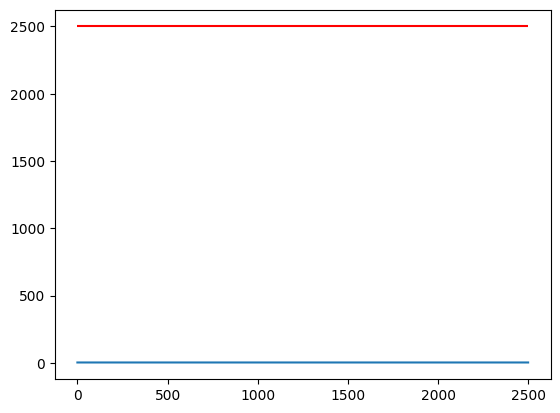

In [801]:
plt.plot(np.arange(0, len(n_singlarvalues)), n_singlarvalues, label="online")
plt.hlines(xmin=0, xmax=len(n_singlarvalues), y=kedmd_mesh.K.shape[0], color="red", label="matrix size")
plt.hlines(xmin=0, xmax=len(n_singlarvalues), y=kedmd_3rdquadrants.s.shape[0], color="green", label="non-online")
plt.ylabel("num of singlar value")
plt.xlabel("n-step")
plt.legend()
plt.show()

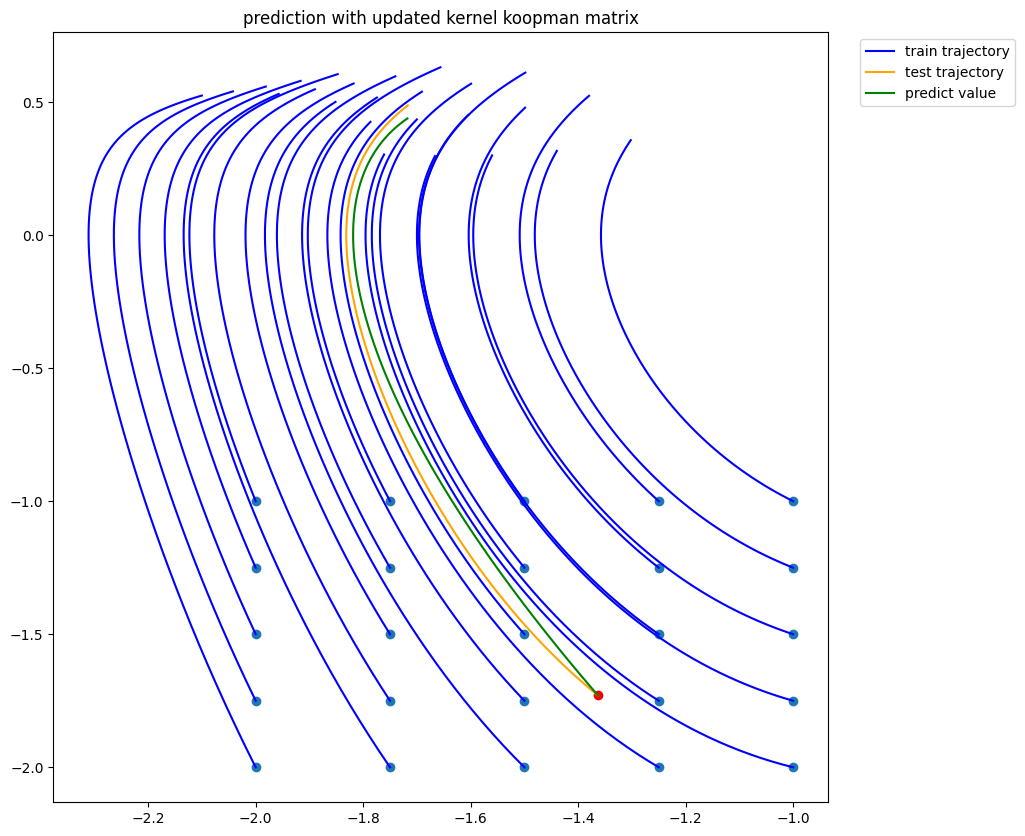

In [802]:
kedmd_mesh.calc_modes()
preds_3rd = [InitTestDataPoint_3.flatten()]
pred = kedmd_mesh.predict(InitTestDataPoint_3.reshape(-1, 1))
preds_3rd.append(pred)
for i in range(TestDataPoint_3.shape[1]-1):
    pred = kedmd_mesh.predict(pred)
    preds_3rd.append(pred)
preds_3rd = np.array(preds_3rd)

#################### 描画　######################
LABEL=True
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X2, Y2)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(OnlineDataPoints[0, i*step+i:(i+1)*step+i], OnlineDataPoints[1, i*step+i:(i+1)*step+i], color="blue", label="train trajectory")
        LABEL=False
    else:
        ax.plot(OnlineDataPoints[0, i*step+i:(i+1)*step+i], OnlineDataPoints[1, i*step+i:(i+1)*step+i], color="blue")
ax.scatter(InitTestDataPoint_3[:,0], InitTestDataPoint_3[:,1], color="red")
ax.plot(TestDataPoint_3[0, :], TestDataPoint_3[1,:], color="orange", label="test trajectory")
ax.plot(preds_3rd[:,0], preds_3rd[:,1], label="predict value", color="green")
ax.set_title("prediction with updated kernel koopman matrix")
ax.legend(bbox_to_anchor=(1.25, 1), loc="upper right")
plt.show()

In [9]:
X_vdp = solution1.y[:, :-1] 
Y_vdp = solution1.y[:, 1:] 

In [10]:
# kernel EDMD
# 閾値
error = []
for i in range(10, 100):
    num_data = i
    # カーネルKoopman行列を求める
    #K_kernel = sp.linalg.inv((G_hat + c*np.eye(M,M))) @ A_hat
    kedmd_poly = kEDMD(X_vdp[:, :num_data], Y_vdp[:, :num_data], kernel="polynomial", p=3, c=1)
    kedmd_gauss = kEDMD(X_vdp[:, :num_data], Y_vdp[:, :num_data], kernel="gaussian", eps=np.sqrt(5))
    
    # K_dmd = Y_vdp[:, :30].T @ np.linalg.pinv(X_vdp[:, :30].T)
    # evals, evec = np.linalg.eig(K_dmd)
    # modes = sp.linalg.pinv(X_vdp[:, :30] @ evec, rtol=1e-3) @ X_vdp
    # efunc = X_vdp[:, :30] @ evec
    # y_dmd = np.real((evals * efunc) @ modes)
    
    
    kedmd_gauss.fit(truncation=1e-5)
    kedmd_poly.fit(truncation=1e-5)
    
    # 予測値を求める
    pred_gauss = [X_vdp[:, num_data]]
    pred_poly = [X_vdp[:, num_data]]
    for x in X_vdp[:, num_data:-1].T:
        pred_gauss.append(kedmd_gauss.predict(x))
        pred_poly.append(kedmd_poly.predict(x))
    y_kedmd_poly = np.array(pred_poly).T
    error.append(np.linalg.norm(Y_vdp[:, num_data:]-y_kedmd_poly, axis=0).mean())
print("done")

done


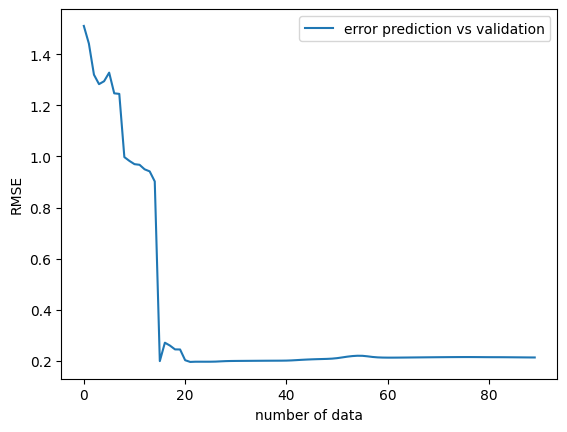

In [11]:
plt.plot(np.arange(0, len(error)), np.array(error), label="error prediction vs validation")
plt.xlabel("number of data")
plt.ylabel("RMSE")
plt.legend()
plt.show()

30
[0.202859480699264]


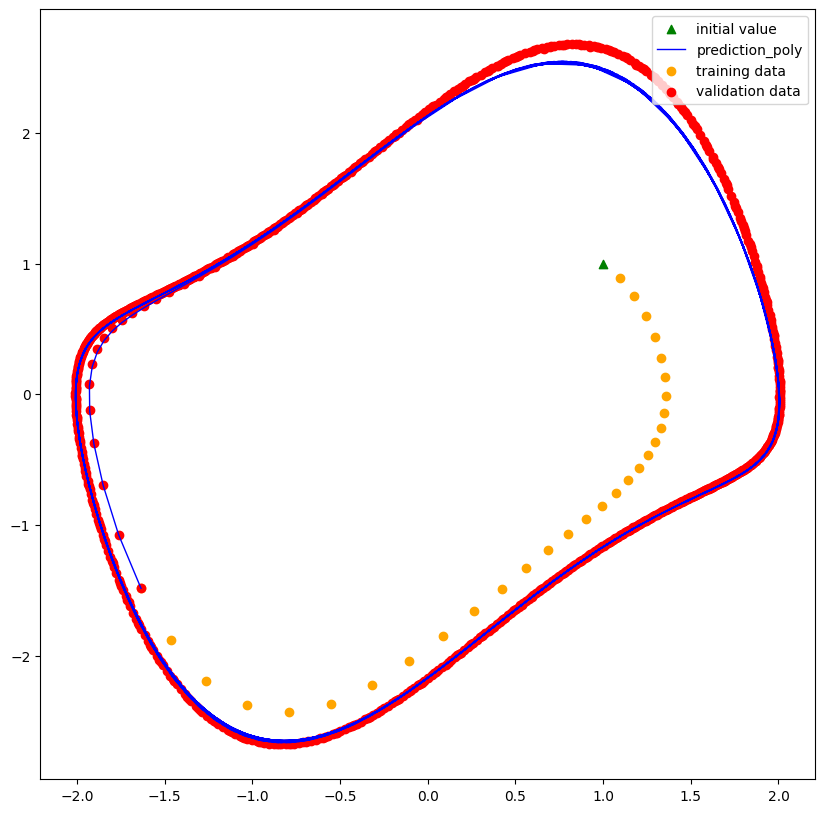

In [12]:
#y_kedmd = np.real((kedmd.eigenvalues * kedmd.eigenfunction) @ kedmd.modes).T
error=[]
num_data = 30
for i in range(num_data, num_data+1):
    num_data = i
    # カーネルKoopman行列を求める
    #K_kernel = sp.linalg.inv((G_hat + c*np.eye(M,M))) @ A_hat
    kedmd_poly = kEDMD(X_vdp[:, :num_data], Y_vdp[:, :num_data], kernel="polynomial", p=3, c=1)
    kedmd_gauss = kEDMD(X_vdp[:, :num_data], Y_vdp[:, :num_data], kernel="gaussian", eps=np.sqrt(5))
    
    # K_dmd = Y_vdp[:, :30].T @ np.linalg.pinv(X_vdp[:, :30].T)
    # evals, evec = np.linalg.eig(K_dmd)
    # modes = sp.linalg.pinv(X_vdp[:, :30] @ evec, rtol=1e-3) @ X_vdp
    # efunc = X_vdp[:, :30] @ evec
    # y_dmd = np.real((evals * efunc) @ modes)
    
    
    kedmd_gauss.fit(truncation=1e-5)
    kedmd_poly.fit(truncation=1e-5)
    
    # 予測値を求める
    pred_gauss = [X_vdp[:, num_data]]
    pred_poly = [X_vdp[:, num_data]]
    for x in X_vdp[:, num_data:-1].T:
        pred_gauss.append(kedmd_gauss.predict(x))
        pred_poly.append(kedmd_poly.predict(x))
    y_kedmd_poly = np.array(pred_poly).T
    error.append(np.linalg.norm(Y_vdp[:, num_data:]-y_kedmd_poly, axis=0).mean())
    print(i)

y_kedmd_gauss = np.array(pred_gauss).T
y_kedmd_poly = np.array(pred_poly).T
print(error)
fig = plt.figure(figsize=(10, 10))
plt.scatter(initial_value[0], initial_value[1], marker="^", color="green", label="initial value")
#plt.plot(y_kedmd_gauss[0], y_kedmd_gauss[1], linewidth=1, label="prediction_gauss", color="red", linestyle="dashdot")
plt.plot(y_kedmd_poly[0], y_kedmd_poly[1], linewidth=1, label="prediction_poly", color="blue", linestyle="solid")
#plt.scatter(y_dmd[0], y_dmd[1], linewidth=1, label="prediction_dmd", color="green")
plt.scatter(Y_vdp[0, :num_data], Y_vdp[1, :num_data], label="training data", color="orange")
plt.scatter(X_vdp[0, num_data:], X_vdp[1, num_data:], label="validation data", color="red")
plt.legend(loc="upper right", fontsize=10)
plt.show()

In [70]:
from scipy.sparse import csr_matrix as sparse_matrix

# scipy.sparse.csr_matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html


def make_differential_ops(nx, dx):

    # operators (matrix) that shift vector components (periodic boundary condition)
    f0 = np.identity(nx, dtype=int)  # f_{i}
    f1 = np.roll(f0, 1, axis=1)  # f_{i+1}
    f2 = np.roll(f0, 2, axis=1)  # f_{i+2}
    f_1 = f1.transpose()  # f_{i-1}
    f_2 = f2.transpose()  # f_{i-2}

    # (f_{i+1} - f_{i-1}) / (2 dx)
    deriv1 = sparse_matrix(f1 - f_1) / (2.0 * dx)

    # (f_{i+1} - 2f_{i} + f_{i-1}) / (dx^2)
    deriv2 = sparse_matrix(f1 - 2.0 * f0 + f_1) / dx**2

    # (f_{i+2} - 2f_{i+1} + 2f_{i-1} - f_{i-2}) / (2 dx^3)
    deriv3 = sparse_matrix(f2 - 2.0 * f1 + 2.0 * f_1 - f_2) / (2.0 * dx**3)

    return deriv1, deriv2, deriv3
coeff_nlin = 6.0
coeff_dis = 1.0
alpha = coeff_nlin/(6.0 * coeff_dis)

[e_1, e_2,e_3]= [-4.0,0.0,2.0]
elliptic_k = (e_3-e_2)/(e_3-e_1)
from scipy.special import ellipj, ellipk


def f_kdv(t, u, df1, df3):
    u_x = df1.dot(u)
    u_xxx = df3.dot(u)
    return coeff_nlin * u * u_x + coeff_dis* u_xxx

def main():
    # x mesh
    sys_length = (2*ellipk(elliptic_k))/np.sqrt(2*(e_3-e_1))
    nx = 50
    x_max = sys_length #100.0　# 本家から変えたところ
    x = np.linspace(-x_max, x_max, nx, endpoint=False)
    dx = x[1] - x[0]
    print("dx =", dx)

    # initial condition
    # 本家から変えた。
    # u0 = np.sin(x * (2.0 * np.pi / x_max))
    [_,cn,_,_] = ellipj(np.sqrt(alpha * (e_3-e_1)/2)*x, elliptic_k)
    u0 = e_2 + (e_3-e_2)* cn **2

    

    # differential operators
    op_df1, _, op_df3 = make_differential_ops(nx, dx)

    print("Solving equation...")
    t_max = 0.5
    sol = solve_ivp(f_kdv, (0, t_max), u0, dense_output=True, args=(op_df1, op_df3), rtol=1e-8)
    print(sol.message)
    print(" Number of time steps :", sol.t.size)
    print(" Minimam time step    :", min(np.diff(sol.t)))
    print(" Maximum time step    :", max(np.diff(sol.t)))

    # t mesh
    nt = 1010
    t = np.linspace(0, t_max, nt)
    dt = t[1] - t[0]
    print("dt =", dt)

    # get u(t, x)
    u_xt = sol.sol(t)  # u(x, t)
    u_tx = u_xt.T  # u(t, x)
    print("shape of u(t, x) :", u_tx.shape)

    # Save results
    np.savez("kdv_solve_ivp", x=x, t=t, u_tx=u_tx)
    return (x, t, u_tx)

x, t, u_tx = main()

dx = 0.04004309521824423
Solving equation...
The solver successfully reached the end of the integration interval.
 Number of time steps : 18523
 Minimam time step    : 2.0676951011600053e-05
 Maximum time step    : 0.0013038190442814213
dt = 0.0004955401387512388
shape of u(t, x) : (1010, 50)


npz.files = ['x', 't', 'u_tx']
x.shape = (50,)
t.shape = (1010,)
u_tx.shape = (1010, 50)
Making animation...
saved as 'kdv_solve_ivp.gif'


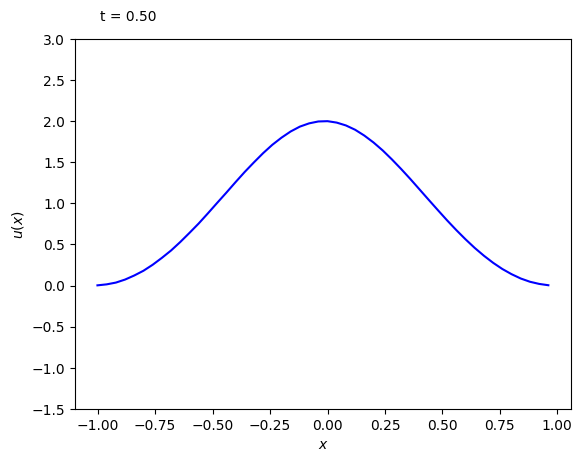

In [71]:
import matplotlib.animation as animation

def save_animation(x, t, u_tx, ymin, ymax, filename):
    fig, ax = plt.subplots()

    # common setting for plot
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x)$")
    ax.set_ylim((ymin, ymax))

    artists = []  # list of plot
    for i in range(t.size):
        # Make i-th plot
        # ax.set_title("t = %f" % t[i])
        artist = ax.plot(x, u_tx[i, :], '-b')
        artist += [ax.text(0.05, 1.05, "t = %.2f" % t[i], transform=ax.transAxes)]
        artists.append(artist)

    # Make animation
    anim = animation.ArtistAnimation(fig, artists, interval=100, repeat=False)
    # plt.show()

    # Save animation
    anim.save(filename, writer="pillow")  # writer="pillow" or "imagemagick" for GIF
    print("saved as '{}'".format(filename))
def load_and_make_anime():
    # Load results
    npz = np.load("kdv_solve_ivp.npz")
    print("npz.files =", npz.files)

    x = npz['x']
    t = npz['t']
    u_tx = npz['u_tx']
    print("x.shape =", x.shape)
    print("t.shape =", t.shape)
    print("u_tx.shape =", u_tx.shape)

    # make an animation
    print("Making animation...")
    save_animation(x, t, u_tx, ymin=-1.5, ymax=3.0, filename="kdv_solve_ivp.gif")
load_and_make_anime()

In [169]:
# dim * data
num_data = 800
X_kdv = u_tx[:-1, :]
Y_kdv = u_tx[1:, :]
# kedmd
kedmd_kdv = kEDMD(X_kdv[:num_data, :].T, Y_kdv[:num_data, :].T, kernel="polynomial", p=2, c=1)
#kedmd_kdv = kEDMD(X_kdv[:num_data, :].T, Y_kdv[:num_data, :].T, kernel="gaussian", eps=np.sqrt(2))
kedmd.fit()
print("kedmd done")

(1009, 50)
kedmd done


validation: 1
validation: 10
validation: 20
validation: 30
validation: 40
validation: 50
validation: 60
validation: 70
validation: 80
validation: 90
validation: 100
[0.011567410317116725, 0.011573130587845785, 0.011566296160465912, 0.011535504269268353, 0.01151504990886576, 0.011567573935257822, 0.011586636166229954, 0.011546069820475735, 0.011560951516690792, 0.011543033786369524, 0.011608201314122098, 0.011535504269268353, 0.011560156862585998, 0.011623649757209207, 0.011511976280625275, 0.011521188542511359, 0.01157736360223292, 0.011584266426556184, 0.011516040923724073, 0.011492439766251436, 0.011515638121266965, 0.011592399367812102, 0.011523927771717691, 0.011523380373401703, 0.011531801507053999, 0.011575353573071698, 0.011531717912490826, 0.011486193735436972, 0.011538259834840331, 0.01159168827319243, 0.011574011543300565, 0.01161657719987804, 0.011507157650580458, 0.011550998513931385, 0.011536795191427715, 0.011533164772364574, 0.011560074707671255, 0.011533097552862673, 0.

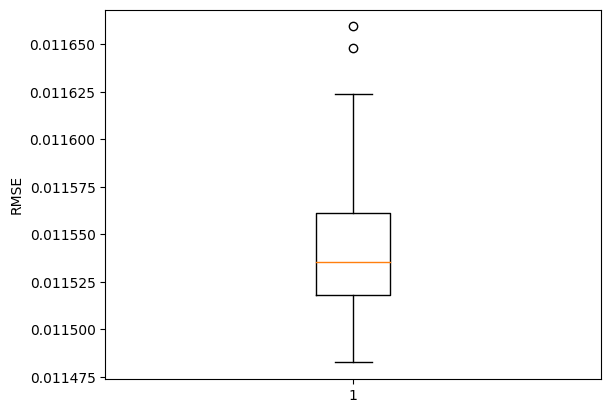

In [196]:
# randomized
# train: ランダムに一定数サンプリングしたデータ集合
# valid: (全データ - train)
# x_valid∈validの1ステップ後を予測，y_valid∈validでRMSEを計測
errors = []
_rng = np.random.default_rng(100)
seeds = _rng.integers(1000, size=100)
for i,seed in enumerate(seeds):
    if i % 10 == 9 or i == 0:
        print("validation: {}".format(i+1))
    rng = np.random.default_rng(seed)
    num_data = 300
    # 全データ集合を訓練データと検証データに分割
    idx = rng.permutation(X_kdv.shape[0])
    idx_train = idx[:num_data]
    idx_valid = idx[num_data:]
    X_kdv_train = X_kdv[idx_train]
    Y_kdv_train = Y_kdv[idx_train]
    X_kdv_valid = X_kdv[idx_valid]
    Y_kdv_valid = Y_kdv[idx_valid]
    
    # カーネルKoopman行列を学習
    kedmd_kdv = kEDMD(X_kdv_train.T, Y_kdv_train.T, kernel="polynomial", p=2, c=1)
    kedmd_kdv.fit()
    error = []
    
    for x_valid, y_valid in zip(X_kdv_valid, Y_kdv_valid):
        x_valid = x_valid.reshape(-1,1)
        y_valid = y_valid.reshape(-1,1)
        e = y_valid - kedmd_kdv.predict(x_valid).reshape(-1,1)
        error.append(np.linalg.norm(e))
    errors.append(np.mean(np.array(error)))
plt.boxplot(errors)
plt.ylabel("RMSE")
plt.show()

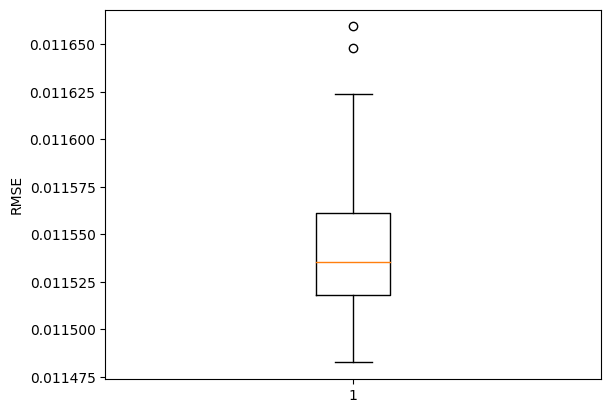

In [199]:
plt.boxplot(errors)
plt.ylabel("RMSE")
plt.show()

In [135]:
t_step = 10 # 各点から3点を予測
preds = []
i = 0
for _ in X_kdv[num_data::t_step, :]:
    _ = _.reshape(-1, 1)
    y = kedmd_kdv.predict(_)
    preds.append(y)
    for i in range(t_step-1):
        y = kedmd_kdv.predict(y)
        preds.append(y)
print(X_kdv.shape)
preds = np.array(preds)
print(preds.shape)

(1009, 50)
(510, 50)


(510, 50)


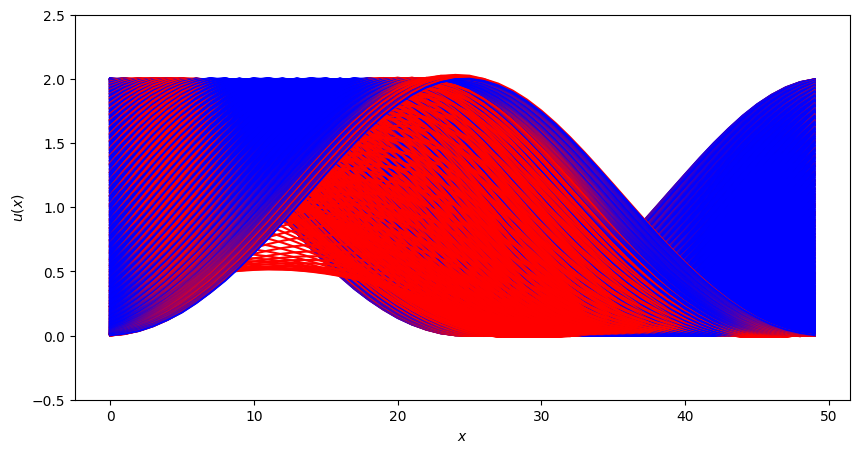

In [136]:
fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax
ax1.set_xlabel("$x$")
ax1.set_ylabel("$u(x)$")
ax1.set_ylim((-0.5, 2.5))
artists = []  # list of plot
print(preds.shape)
for i in range(preds.shape[0]-1):
    artist1 = ax1.plot(preds[i, :], '-r')
    artist2 = ax1.plot(Y_kdv[num_data+i, :], '-b')
    artists.append(artist1+artist2)

# Make animation
anim = animation.ArtistAnimation(fig, artists, interval=11, repeat=False)
plt.show()
# Save animation
anim.save("kedmd_prediction.gif", writer="pillow")  # writer="pillow" or "imagemagick" for GIF

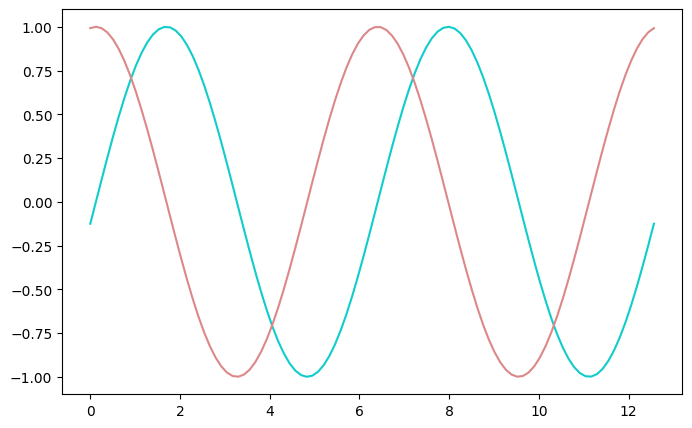

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

lim = 50
xs = np.linspace(0, 4*np.pi, 100)
images = []

for i in range(lim):
    theta = i*2*np.pi/lim
    ys1 = np.sin(xs+theta)
    ys2 = np.cos(xs+theta)
    image1 = ax.plot(xs, ys1, c="#11cccc")
    image2 = ax.plot(xs, ys2, c="#dd8888")

    images.append(image1 + image2)

anime = animation.ArtistAnimation(fig, images, interval=40, blit=True, repeat_delay=0)
anime.save("sin_cos.gif", writer="pillow")
plt.show()

1. 簡単な系（VdP）
2. KdV
3. パラメータ変化に対してできるか
4. ランダムにスナップショットを選んで学習（ex 40個学習・１０個でvalidation）
5. 初期値10個ー＞40個まで（データを増やしてどうか, windowなしverとwindowありverを比べる）
6. 偏微分系